<font size=7>Čitanje podataka</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

filename = './input/data.csv'
full_data = pd.read_csv(filename) # full data frame

data = full_data.copy() # Data frame for analysing

print("Karakteristike (kolone): ")
print(data.columns)

print("Broj karakteristika koje treba analizirati ", len(data.columns)-1)
print("Broj redova ", data.shape[0])


Karakteristike (kolone): 
Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')
Broj karakteristika koje treba analizirati  24
Broj redova  30697


In [2]:

nan_flag_mask = data['shot_made_flag'].isnull() # return true for columns thar are NaN, false for other
nan_data = data[nan_flag_mask] # take nan date, which shot flag need to be predict
non_nan_data = data[~nan_flag_mask] # take non nan data, which will need to be analysed for prediction.

print("Broj podataka koje treba predvideti: ", len(nan_data['shot_made_flag']))
print("Broj podataka iz kojih će algoritam učiti: ", len(non_nan_data['shot_made_flag']))

non_nan_data["shot_made_flag"] = non_nan_data["shot_made_flag"].astype('int64')

Broj podataka koje treba predvideti:  5000
Broj podataka iz kojih će algoritam učiti:  25697


<font size=6>**ANALIZA KARAKTERISTIKA I UTICAJ NA USPEŠNOST ŠUTA**</font>


<font size="5">**action_type**</font>



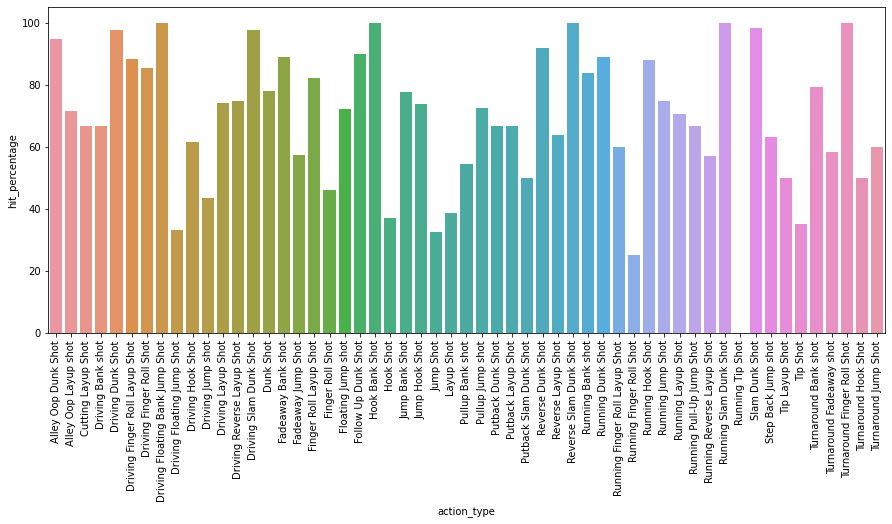

In [3]:

data_action_type = non_nan_data.groupby(['action_type']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_action_type['hit_percentage'] = 100 * data_action_type['hit_sum'] / data_action_type['count']

plt.figure(figsize=(15,6))
sns.barplot(x='action_type', y='hit_percentage', data=data_action_type)
plt.xticks(rotation='vertical')
plt.show()


Sa grafika se vidi velika zavisnost šuta u odnosu na tip akcije.

<font size=5>**combined_shot_type**</font>

<AxesSubplot:xlabel='combined_shot_type', ylabel='hit_percentage'>

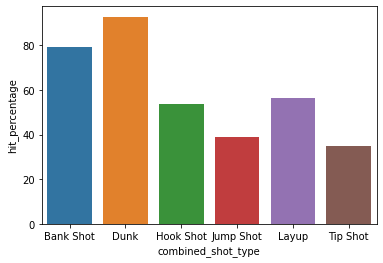

In [4]:

data_combined_shot_type = non_nan_data.groupby(['combined_shot_type']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_combined_shot_type['hit_percentage'] = 100 * data_combined_shot_type['hit_sum'] / data_combined_shot_type['count']

sns.barplot(x=data_combined_shot_type['combined_shot_type'], y=data_combined_shot_type['hit_percentage'])

Sa grafika se vidi velika zavisnost uspešnosti šuta na kombinovani tip šuta.

<font size=5>**game_event_id** and **game_id**</font>

Ova kolona predstavlja ID utakmice. Sam id ne utiče na uspešnost šuta. Na to utiču neki drugi faktori koji su se desili na utakmici. Iz samog broja ne možemo ništa izvući.

<span style="color:red">**DROP game_event_id, game_id**</span>

<font size=5>**lat, lon, loc_x, loc_y**</font>

Date karakteristike predstavljaju pozicuju šuta. Logično je da distanca šuta utiče na uspešnost. Šut bliži košu ima veću verovatnoću da bude uspešan.

Lat, lon i loc_x, loc_y su slične informacije. Lat (latitude) je geografska širina i lon (longitude) je geografska dužina, i te informacije su potpuno u skladu sa loc_x i loc_y odnosno pozicija na x i y osi samog terena. Tako da je dovoljno analizirati samo loc_x i loc_y.

<span style="color:red">**DROP lat i lon**</span>

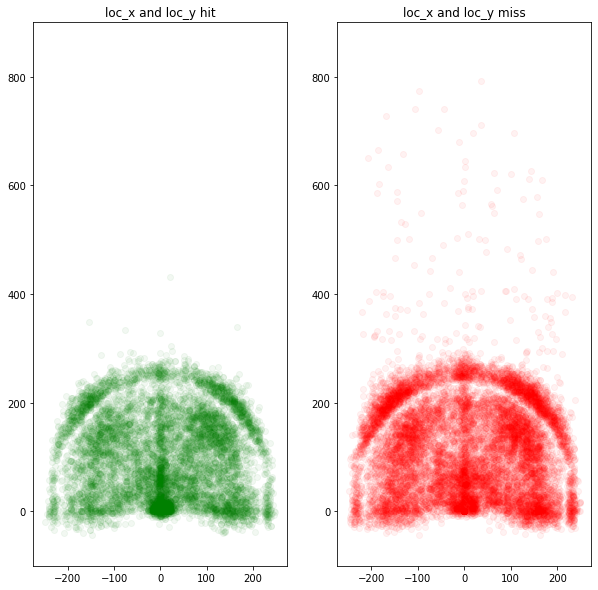

In [5]:

data_shot_loc_hit = non_nan_data.loc[non_nan_data['shot_made_flag']==1][['loc_x', 'loc_y']]
data_shot_loc_miss = non_nan_data.loc[non_nan_data['shot_made_flag']==0][['loc_x', 'loc_y']]

alpha = 0.05
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.scatter(data_shot_loc_hit['loc_x'], data_shot_loc_hit['loc_y'], color='green', alpha=alpha)
plt.title('loc_x and loc_y hit')
plt.ylim(-100, 900)

plt.subplot(122)
plt.scatter(data_shot_loc_miss['loc_x'], data_shot_loc_miss['loc_y'], color='red', alpha=alpha)
plt.title('loc_x and loc_y miss')
plt.ylim(-100, 900)
plt.show()

Najgušći broj pogodaka je bliže tački 0,0. U svakom slučaju lokacija šuta utiče na uspešnost pogotka.

<font size=5>**Time - minutes and seconds remaining**</font>

<Figure size 1080x1080 with 0 Axes>

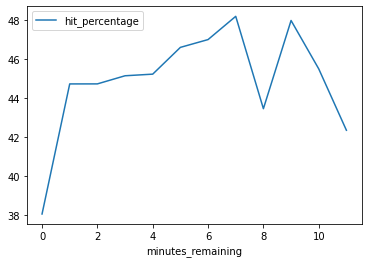

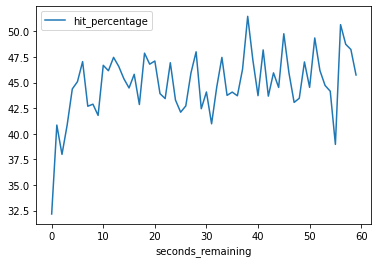

In [6]:

data_min_remaining = non_nan_data.groupby(['minutes_remaining']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_min_remaining['hit_percentage'] = 100 * data_min_remaining['hit_sum'] / data_min_remaining['count']

data_sec_remaining = non_nan_data.groupby(['seconds_remaining']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_sec_remaining['hit_percentage'] = 100 * data_sec_remaining['hit_sum'] / data_sec_remaining['count']

plt.figure(figsize=(15,15))
data_min_remaining.plot(x='minutes_remaining', y='hit_percentage')
data_sec_remaining.plot(x='seconds_remaining', y='hit_percentage')
plt.show()


Sa grafika se vidi da se u poslednjim minutima i sekundama uspešnost smanjuje. Dakle poslednjih 4 sekunde je kritično.

<font size=5>**period**</font>

<Figure size 1080x1080 with 0 Axes>

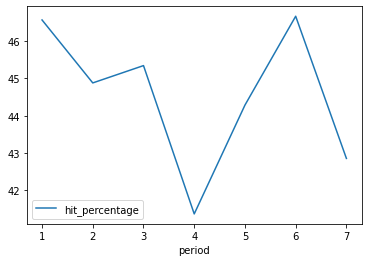

In [7]:

data_period = non_nan_data.groupby(['period']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_period['hit_percentage'] = 100 * data_period['hit_sum'] / data_period['count']

plt.figure(figsize=(15,15))
data_period.plot(x='period', y='hit_percentage')
plt.show()


Grafik je dosta promenljiv za ovu karakteristiku. Dakle period može uticati na uspešnost šuta.

<font size=5>**playoffs**</font>

[Text(0, 0, '44.642'), Text(0, 0, '44.4651')]

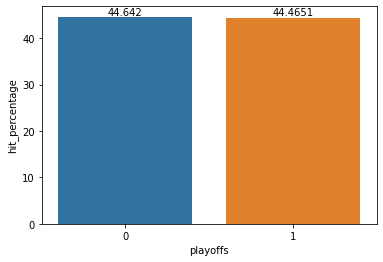

In [8]:

data_playoffs = non_nan_data.groupby(['playoffs']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_playoffs['hit_percentage'] = 100 * data_playoffs['hit_sum'] / data_playoffs['count']


bp = sns.barplot(x=data_playoffs['playoffs'], y=data_playoffs['hit_percentage'], data=data_playoffs)
bp.bar_label(bp.containers[0])



Sa grafika vidimo da se za obe vrednosti karakteristike ***playoffs*** prosečna vrednost uspešnosti šuta ne razlikuje puno. Dakle možemo izbaciti datu karakteristiku.

<span style="color:red">**DROP playoffs**</span>

<font size=5>**season**</font>

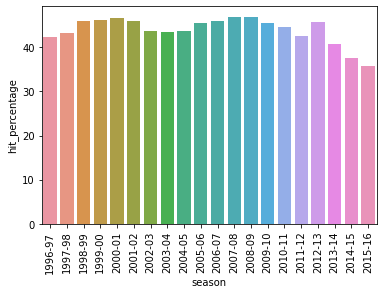

In [9]:
data_season = non_nan_data.groupby(['season']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_season['hit_percentage'] = 100 * data_season['hit_sum'] / data_season['count']

sns.barplot(x=data_season['season'], y=data_season['hit_percentage'], data=data_season)
plt.xticks(rotation='vertical')
plt.show()

Sa grafika se vidi da su performanse iste skoro za sve sezone. Ova karakteristika nije ključna za kalkulaciju.

<span style="color:red">**DROP season**</span>

<font size=5>**shot_distance**</font>

Za datu karakteristiku intuitivno možemo reći da je jako bitna za predikciju, jer što je šut bliži košu, veća je verovatnoća za pogodak.

<Figure size 1080x1080 with 0 Axes>

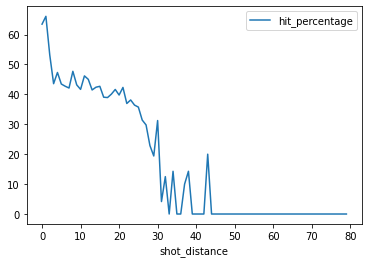

In [10]:
data_shot_distance = non_nan_data.groupby(['shot_distance']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_shot_distance['hit_percentage'] = 100 * data_shot_distance['hit_sum'] / data_shot_distance['count']

plt.figure(figsize=(15,15))
data_shot_distance.plot(x='shot_distance', y='hit_percentage')
plt.show()

Dakle sa grafika vidimo da je sa manjom udaljenošću od koša, uspešnost šuta daleko veća.

<font size=5>**shot_type**</font>

[Text(0, 0, '47.7348'), Text(0, 0, '32.9268')]

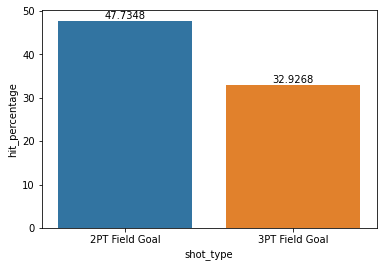

In [11]:
data_shot_type = non_nan_data.groupby(['shot_type']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_shot_type['hit_percentage'] = 100 * data_shot_type['hit_sum'] / data_shot_type['count']


bp = sns.barplot(x=data_shot_type['shot_type'], y=data_shot_type['hit_percentage'], data=data_shot_type)
bp.bar_label(bp.containers[0])

U zavisnosti od toga koji je tip šuta, zavisiće i procenat uspešnosti šuta. 

<font size=5>**shot_zone_area, shot_zone_basic, shot_zone_range**</font>

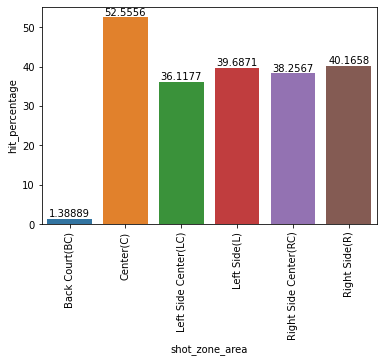

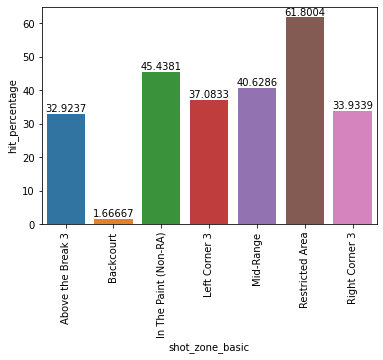

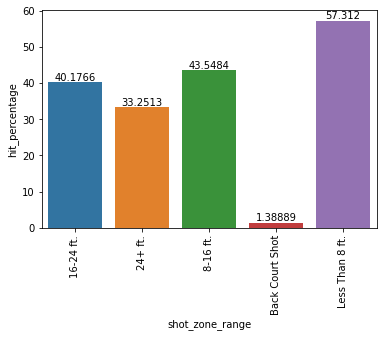

In [12]:
data_shot_zone_area = non_nan_data.groupby(['shot_zone_area']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_shot_zone_area['hit_percentage'] = 100 * data_shot_zone_area['hit_sum'] / data_shot_zone_area['count']

data_shot_zone_basic = non_nan_data.groupby(['shot_zone_basic']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_shot_zone_basic['hit_percentage'] = 100 * data_shot_zone_basic['hit_sum'] / data_shot_zone_basic['count']

data_shot_zone_range = non_nan_data.groupby(['shot_zone_range']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_shot_zone_range['hit_percentage'] = 100 * data_shot_zone_range['hit_sum'] / data_shot_zone_range['count']

bp = sns.barplot(x=data_shot_zone_area['shot_zone_area'], y=data_shot_zone_area['hit_percentage'], data=data_shot_zone_area)
bp.bar_label(bp.containers[0])
plt.xticks(rotation='vertical')
plt.show()

bp = sns.barplot(x=data_shot_zone_basic['shot_zone_basic'], y=data_shot_zone_basic['hit_percentage'], data=data_shot_zone_basic)
bp.bar_label(bp.containers[0])
plt.xticks(rotation='vertical')
plt.show()

bp = sns.barplot(x=data_shot_zone_range['shot_zone_range'], y=data_shot_zone_range['hit_percentage'], data=data_shot_zone_range)
bp.bar_label(bp.containers[0])
plt.xticks(rotation='vertical')
plt.show()

Date karakteristike utiču na uspešnost šuta.

<font size=5>**team_id, team_name**</font>

In [13]:
print(non_nan_data['team_id'].unique())
print(non_nan_data['team_name'].unique())

[1610612747]
['Los Angeles Lakers']


Kobe je uvek igrao za isti tim. Tako da ove dve karakteristike možemo da zanemarimo.

<span style="color:red">**DROP team_id, team_name**</span>

<font size=5>**game_date**</font>

<Figure size 1080x1080 with 0 Axes>

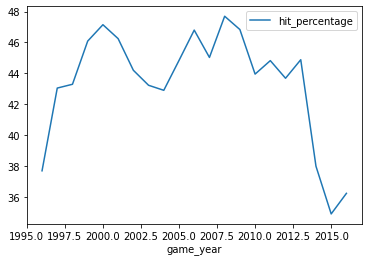

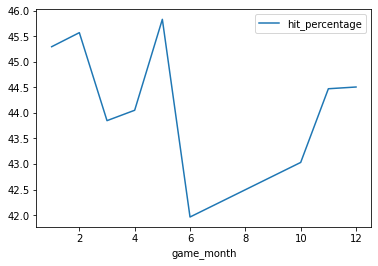

In [14]:
non_nan_data['game_date'] = pd.to_datetime(non_nan_data['game_date'])
non_nan_data['game_year'] = non_nan_data['game_date'].dt.year
non_nan_data['game_month'] = non_nan_data['game_date'].dt.month

data_game_year = non_nan_data.groupby(['game_year']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_game_year['hit_percentage'] = 100 * data_game_year['hit_sum'] / data_game_year['count']

data_game_month = non_nan_data.groupby(['game_month']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_game_month['hit_percentage'] = 100 * data_game_month['hit_sum'] / data_game_month['count']

plt.figure(figsize=(15,15))
data_game_year.plot(x='game_year', y='hit_percentage')
plt.show()
data_game_month.plot(x='game_month', y='hit_percentage')
plt.show()


Obrisaćemo ***game_date*** a sačuvaćemo ***game_year*** i ***game_month***. Deluje da godina i mesec potencijalno mogu uticati na uspešnost pogotka.

<span style="color:red">**DROP game_date**</span>

<font size=5>**matchup**</font>

[Text(0, 0, '44.642'), Text(0, 0, '44.4651')]

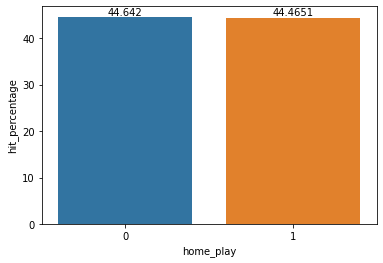

In [15]:
non_nan_data['home_play'] = non_nan_data['matchup'].str.contains('vs').astype('int')

data_home_play = non_nan_data.groupby(['home_play']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_home_play['hit_percentage'] = 100 * data_home_play['hit_sum'] / data_home_play['count']

bp = sns.barplot(x=data_home_play['home_play'], y=data_playoffs['hit_percentage'], data=data_home_play)
bp.bar_label(bp.containers[0])


U ***matchup*** koloni dobijamo informaciju o Kobijevom timu, protivničkom timu, da li se igra na domaćem terenu (*vs*) ili na protivničkom (*@*). Informacija o protivniku se nalazi u posebnoj koloni ***oponent*** koju ćemo analizirati kasnije, tako da nam ta informacija nije potrebna.
<br>
Sa grafika se vidi da da li se igra na domaćem ili protivničkom terenu ne utiče puno na uspešnost, tako da ovu karakteristiku možemo obrisati.

<span style="color:red">**DROP matchup**</span>

<font size=5>**opponent**</font>

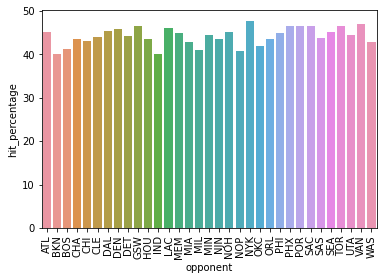

In [16]:
data_opponent = non_nan_data.groupby(['opponent']).agg({'shot_made_flag':'sum','game_id':'count'}).reset_index().rename(columns={'shot_made_flag':'hit_sum', 'game_id':'count'})
data_opponent['hit_percentage'] = 100 * data_opponent['hit_sum'] / data_opponent['count']

sns.barplot(x=data_opponent['opponent'], y=data_opponent['hit_percentage'], data=data_opponent)
plt.xticks(rotation='vertical')
plt.show()

Sa grafika vidimo da protivnik ne utiče mnogo na uspešnost šuta. Sa svakim protivnikom uspešnpst je bila pšrilično ista.

<span style="color:red">**DROP opponent**</span>

<font size=5>**shot_id**</font>

Iz date kolone ne možemo izvući nikakve podatke za predikciju.

<span style="color:red">**DROP shot_id**</span>

<font size=6>**BRISANJE NEPOTREBNIH KOLONA I TRNSFORMACIJA PODATAKA**</font>

<font size=4> Priprema podataka za učenje</font>

In [17]:
from sklearn.preprocessing import LabelEncoder
import xgboost
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
import time

data = full_data.copy()

data['game_date'] = pd.to_datetime(data['game_date'])
data['game_year'] = data['game_date'].dt.year
data['game_month'] = data['game_date'].dt.month

data['time_remaining'] = 60 * data['minutes_remaining'] + data['seconds_remaining']
data['time_under_5'] = data['time_remaining'] < 5

drops = ['game_id', 'game_event_id', 'shot_id', 'opponent', 'matchup', 'game_date', 'team_id', 'team_name' , 'season', 'playoffs', 'lat', 'lon', 'seconds_remaining', 'minutes_remaining', 'time_remaining', 'shot_made_flag']

data_predictors = data.copy()
for drop in drops:
    data_predictors = data_predictors.drop(drop, 1)

predictor_columns = data_predictors.columns

le = LabelEncoder()
for col in predictor_columns:
    if data[col].dtype=='object':
        data[col] = le.fit_transform(data[col])

nan_flag_mask = data['shot_made_flag'].isnull()
data_result = data[nan_flag_mask]
data_training = data[~nan_flag_mask]

data_result.index = range(len(data_result))
data_training.index = range(len(data_training))

kf = KFold(shuffle=True, n_splits=10, random_state=50)


<font size=5> **Boost algoritmi**</font>

<font size=4> **Extreme Gradient Boost**</font>

In [18]:

xgb = xgboost.XGBClassifier(seed=1, learning_rate=0.01, n_estimators=500, silent=False, max_depth=7, subsample=0.6, colsample_bytree=0.6, verbosity=0)

def run_test_xgb(predictors):
    all_score = []
    for train_index, test_index in kf.split(data_training):
        xgb.fit(data_training.loc[train_index, predictors], data_training.loc[train_index, 'shot_made_flag'])
        score = metrics.log_loss(data_training.loc[test_index, 'shot_made_flag'], xgb.predict_proba(data_training.loc[test_index, predictors])[:,1])
        all_score.append(score)
        print(score)
    print('Mean score =', np.array(all_score).mean())

start = time.time()
run_test_xgb(predictor_columns)
end = time.time()
print("Time = ", end-start)

xgb.fit(data_training[predictor_columns], data_training['shot_made_flag'])
xgb.predict_proba(data_result[predictor_columns])[:,1]
preds = xgb.predict_proba(data_result[predictor_columns])
data_result['shot_made_flag'] = xgb.predict_proba(data_result[predictor_columns])[:,1]
result = data_result[['shot_id', 'shot_made_flag']]
result.to_csv('./output/result_xgb.csv', index=False)

0.6076413601417615
0.6011794724332357
0.6022798719859119
0.6157184104905128
0.6066564320429253
0.5909227142944277
0.6040324264055369
0.6251442130300652
0.6064740253677422
0.5984867443790118
Mean score = 0.6058535670571131
Time =  34.329468965530396


<font size=4> **Gradient Boost**</font>

In [19]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_depth=7, random_state=1)

def run_test_gb(predictors):
    all_score = []
    for train_index, test_index in kf.split(data_training):
        gb.fit(data_training.loc[train_index, predictors], data_training.loc[train_index, 'shot_made_flag'])
        score = metrics.log_loss(data_training.loc[test_index, 'shot_made_flag'], gb.predict_proba(data_training.loc[test_index, predictors])[:,1])
        all_score.append(score)
        print(score)
    print('Mean score =', np.array(all_score).mean())

start = time.time()
run_test_gb(predictor_columns)
end = time.time()
print("Time = ", end-start)

gb.fit(data_training[predictor_columns], data_training['shot_made_flag'])
gb.predict_proba(data_result[predictor_columns])[:,1]
preds = gb.predict_proba(data_result[predictor_columns])
data_result['shot_made_flag'] = gb.predict_proba(data_result[predictor_columns])[:,1]
result = data_result[['shot_id', 'shot_made_flag']]
result.to_csv('./output/result_gb.csv', index=False)


0.6117578221379223
0.6024661221451122
0.6071941610949528
0.6172004358429939
0.6057435113970401
0.5951398691552904
0.609139454111856
0.626940263513912
0.6105946235388928
0.6027961911788123
Mean score = 0.6088972454116784
Time =  216.5245702266693


<font size=4> **Ada Boost**</font>

In [20]:

ab = AdaBoostClassifier(n_estimators=500, learning_rate=0.01, random_state=1)

def run_test_ab(predictors):
    all_score = []
    for train_index, test_index in kf.split(data_training):
        ab.fit(data_training.loc[train_index, predictors], data_training.loc[train_index, 'shot_made_flag'])
        score = metrics.log_loss(data_training.loc[test_index, 'shot_made_flag'], ab.predict_proba(data_training.loc[test_index, predictors])[:,1])
        all_score.append(score)
        print(score)
    print('Mean score =', np.array(all_score).mean())

start = time.time()
run_test_ab(predictor_columns)
end = time.time()
print("Time = ", end-start)

ab.fit(data_training[predictor_columns], data_training['shot_made_flag'])
ab.predict_proba(data_result[predictor_columns])[:,1]
preds = ab.predict_proba(data_result[predictor_columns])
data_result['shot_made_flag'] = ab.predict_proba(data_result[predictor_columns])[:,1]
result = data_result[['shot_id', 'shot_made_flag']]
result.to_csv('./output/result_ab.csv', index=False)


0.6692557297508024
0.6684283995150638
0.6688581541972094
0.6703962739141321
0.6699744278314346
0.666784000143643
0.6692700414017424
0.6715358037571298
0.6699695110907155
0.6683289764583815
Mean score = 0.6692801318060255
Time =  59.72605109214783


<font size=5> **Bagging (Bootstrap Aggregation) alogoritmi**</font>

<font size=4> **Bagged Decision Trees**</font>

In [21]:


bdt = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500, random_state=1)

def run_test_bdt(predictors):
    all_score = []
    for train_index, test_index in kf.split(data_training):
        bdt.fit(data_training.loc[train_index, predictors], data_training.loc[train_index, 'shot_made_flag'])
        score = metrics.log_loss(data_training.loc[test_index, 'shot_made_flag'], bdt.predict_proba(data_training.loc[test_index, predictors])[:,1])
        all_score.append(score)
        print(score)
    print('Mean score =', np.array(all_score).mean())

start = time.time()
run_test_bdt(predictor_columns)
end = time.time()
print("Time = ", end-start)

bdt.fit(data_training[predictor_columns], data_training['shot_made_flag'])
bdt.predict_proba(data_result[predictor_columns])[:,1]
preds = bdt.predict_proba(data_result[predictor_columns])
data_result['shot_made_flag'] = bdt.predict_proba(data_result[predictor_columns])[:,1]
result = data_result[['shot_id', 'shot_made_flag']]
result.to_csv('./output/result_bdt.csv', index=False)

0.7187055545266374
0.6945626763314274
0.694056674657786
0.6951787251471849
0.7328899893511757
0.6826987511516837
0.7241229064439585
0.7648308233456966
0.6925391476418512
0.7074752294761094
Mean score = 0.710706047807351
Time =  463.12094497680664


<font size=4> **Random Forest**</font>

In [22]:

rf = RandomForestClassifier(n_estimators=500, max_features=10)

def run_test_rf(predictors):
    all_score = []
    for train_index, test_index in kf.split(data_training):
        rf.fit(data_training.loc[train_index, predictors], data_training.loc[train_index, 'shot_made_flag'])
        score = metrics.log_loss(data_training.loc[test_index, 'shot_made_flag'], rf.predict_proba(data_training.loc[test_index, predictors])[:,1])
        all_score.append(score)
        print(score)
    print('Mean score =', np.array(all_score).mean())

start = time.time()
run_test_rf(predictor_columns)
end = time.time()
print("Time = ", end-start)

rf.fit(data_training[predictor_columns], data_training['shot_made_flag'])
rf.predict_proba(data_result[predictor_columns])[:,1]
preds = rf.predict_proba(data_result[predictor_columns])
data_result['shot_made_flag'] = rf.predict_proba(data_result[predictor_columns])[:,1]
result = data_result[['shot_id', 'shot_made_flag']]
result.to_csv('./output/result_rf.csv', index=False)

0.7162053126382688
0.6717329159034794
0.6763293462515902
0.6963452349211693
0.6963820280190447
0.6815267308919903
0.698493633831166
0.7648777074792327
0.6793252971581153
0.726864650865944
Mean score = 0.7008082857960001
Time =  267.25720977783203


<font size=4> **Extra Trees**</font>

In [23]:
et = RandomForestClassifier(n_estimators=500, max_features=10)

def run_test_et(predictors):
    all_score = []
    for train_index, test_index in kf.split(data_training):
        et.fit(data_training.loc[train_index, predictors], data_training.loc[train_index, 'shot_made_flag'])
        score = metrics.log_loss(data_training.loc[test_index, 'shot_made_flag'], et.predict_proba(data_training.loc[test_index, predictors])[:,1])
        all_score.append(score)
        print(score)
    print('Mean score =', np.array(all_score).mean())

start = time.time()
run_test_et(predictor_columns)
end = time.time()
print("Time = ", end-start)

et.fit(data_training[predictor_columns], data_training['shot_made_flag'])
et.predict_proba(data_result[predictor_columns])[:,1]
preds = et.predict_proba(data_result[predictor_columns])
data_result['shot_made_flag'] = et.predict_proba(data_result[predictor_columns])[:,1]
result = data_result[['shot_id', 'shot_made_flag']]
result.to_csv('./output/result_et.csv', index=False)

0.7279884273128766
0.70583235578464
0.6770671206843074
0.7170910117053623
0.6739502886596128
0.6670223848267476
0.6858465321341419
0.717893758390157
0.6879644576360422
0.7147635591533994
Mean score = 0.6975419896287287
Time =  271.1591341495514
